In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.graph_objects as go

In [2]:
df = pd.read_csv("C:/Users/Andra/Desktop/dados_limpos/despesas_senadores_por_dia.csv")

In [3]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(df)
future = m.make_future_dataframe(periods=365, freq="D")
forecast = m.predict(future)

14:31:18 - cmdstanpy - INFO - Chain [1] start processing
14:31:18 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
df_2023 = pd.read_csv("C:/Users/Andra/Downloads/despesas_ceaps_2023.csv", sep=";")

In [5]:
df_2023["DATA"] = pd.to_datetime(df_2023["DATA"], format="%Y/%m/%d")

In [6]:
dados_2023 = pd.DataFrame(df_2023.groupby(df_2023["DATA"].dt.date)["VALOR_REEMBOLSADO"].sum().reset_index()).rename(columns={'DATA': 'ds', 'VALOR_REEMBOLSADO': 'y'})

In [7]:
dados_2023["ds"] = pd.to_datetime(dados_2023["ds"], format="%Y/%m/%d")
dados_2023.drop(dados_2023[dados_2023["ds"].dt.year != 2023].index, inplace=True)

In [8]:
dados_2023_filtrados =  dados_2023[dados_2023["ds"].dt.month <=4]

In [9]:
df_forecast = forecast[(forecast["ds"].dt.month <= 4) & (forecast["ds"].dt.year == 2023)][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index().drop("index", axis=1)

## Aplicando MAPE

In [15]:
resultado = dados_2023_filtrados.merge(df_forecast, on="ds", how="inner")
resultado["erro_absoluto"] = np.fabs(resultado["y"] - abs(resultado["yhat"])) / resultado["y"]
resultado.head()

,ds,y,yhat,yhat_lower,yhat_upper,erro_absoluto
0,2023-01-01,47946.27,-9209.603920,-94334.138923,70684.302205,0.807918
1,2023-01-02,82496.06,75428.443368,-15343.255628,159642.029912,0.085672
2,2023-01-03,74372.01,58968.419196,-26516.103784,145534.221707,0.207115
3,2023-01-04,42175.98,59892.883453,-30136.680280,152614.170319,0.420071
4,2023-01-05,52432.32,51020.591520,-38968.475489,136765.852682,0.026925


In [24]:
mape = resultado["erro_absoluto"].mean()
mape

0.0018598712566469222

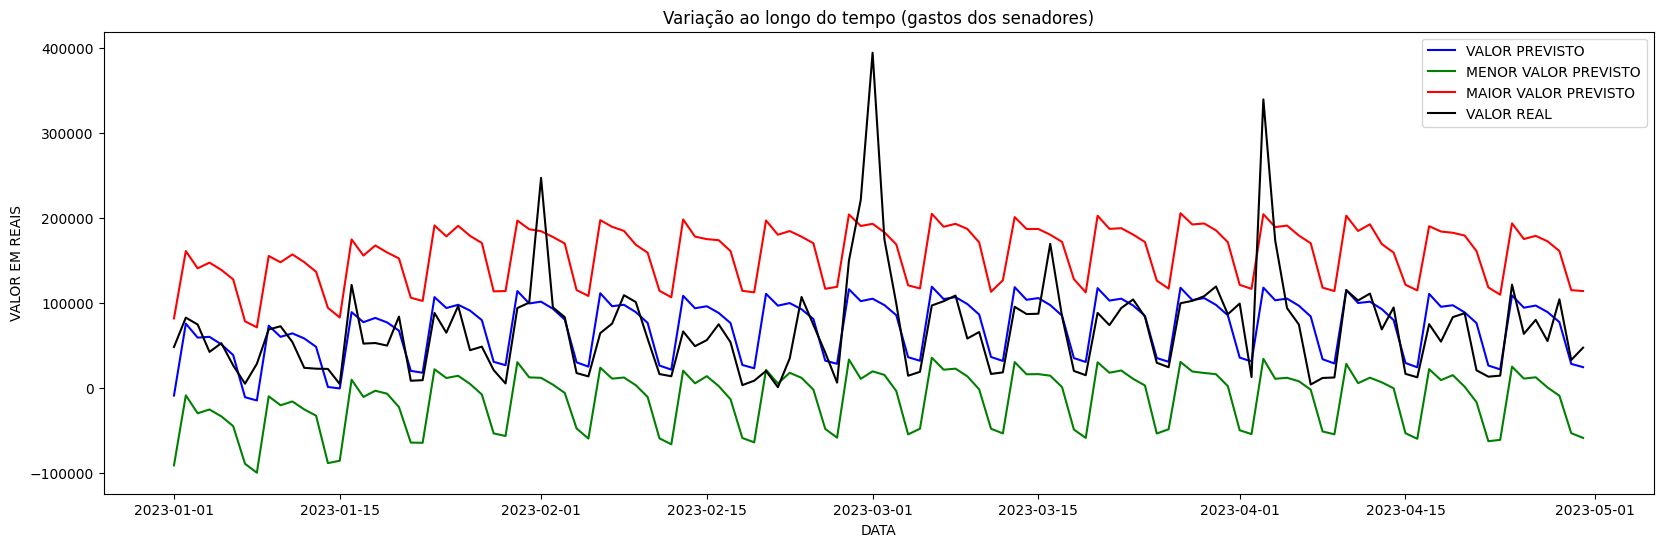

In [10]:
import matplotlib.pyplot as plt

ds = df_forecast["ds"]
yhat = df_forecast["yhat"]
yhat_lower = df_forecast["yhat_lower"]
yhat_upper = df_forecast["yhat_upper"]
y = dados_2023_filtrados["y"]

plt.figure(figsize=(20, 6))

plt.plot(ds, yhat, label="VALOR PREVISTO", color="blue")
plt.plot(ds, yhat_lower, label="MENOR VALOR PREVISTO", color="green")
plt.plot(ds, yhat_upper, label="MAIOR VALOR PREVISTO", color="red")
plt.plot(ds, y, label="VALOR REAL", color="black")

plt.xlabel("DATA")
plt.ylabel("VALOR EM REAIS")
plt.title("Variação ao longo do tempo (gastos dos senadores)")
plt.legend()

plt.show()